<a href="https://colab.research.google.com/github/farahshahhoud/Machine_Learning/blob/master/PK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Цель работы
Классификация текстов на арабском языке с использованием разных видов классификаторов нормальных и наивных байесовских классификаторов.

#Набор данных
Набор данных представляет собой набор арабских текстов, который охватывает современный арабский язык, используемый в газетных статьях.  

Набор данных состоит из 111 728 документов и 319 254 124 слов, структурированных в текстовых файлах и собранных из 3 арабских онлайн-газет: Assabah [9], Hespress [10] и Akhbarona [11] с использованием полуавтоматического процесса сканирования в Интернете.  

Документы в наборе данных подразделяются на 5 классов: спортивные, политические, культурные, экономические и разнообразные.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")


Глядя на первые пять строк нашего набора данных:

In [0]:
data = pd.read_csv("/content/drive/My Drive/arabic_dataset_classifiction.csv",names = ['text', 'target']) 
data.head()

,text,target
0,text,targe
1,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
2,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
3,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
4,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0


In [0]:
def accuracy_score_for_classes(    
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int,Tuple[float,float]]:

    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        temp_f1=f1_score(temp_data_flt['t'].values, 
            temp_data_flt['p'].values, average='micro')
        # сохранение результата в словарь
        res[c] = (temp_acc,temp_f1)
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy \t \t f1_score')
    for i in accs:
        print('{} \t {} \t {}'.format(i, accs[i][0],accs[i][1]))
   

Количество строки в нашем наборе данных:

In [0]:
data.shape

(111729, 2)

In [0]:
data.text.shape

(111729,)

In [0]:
data.target.shape

(111729,)

Итак, мы увидели, что в нашем наборе данных есть несколько строк с нулевым значением.    
Чтобы справиться с этим, мы собираемся включить все строки с нулевым значением и оставить только те, которые на самом деле содержат данные.

In [0]:
data=data.dropna()

Наша новая форма данных:

In [0]:
data.shape

(108790, 2)

In [0]:
vocab_list = data['text'].tolist()
vocab_list[1:10]

['بين أستوديوهات ورزازات وصحراء مرزوكة وآثار وليلي ثم الرباط والبيضاء انتهى المخرج المغربي سهيل بن بركة من تصوير مشاهد عمله السينمائي الجديد الذي خصصه لتسليط الضوء عن حياة الجاسوس الإسباني دومينغو باديا الذي عاش فترة من القرن التاسع عشر بالمغرب باسم علي باي هذا الفيلم الذي اختار له مخرجه عنوان حلم خليفة يصور حياة علي باي العباسي الذي ما زال أحد أحياء طنجة يحمل اسمه عاش حياة فريدة متنكرا بشخصية تاجر عربي من سلالة الرسول صلى الله عليه وسلم فيما كان يعمل جاسوسا لحساب إسبانيا وكشف مخرج الفيلم سهيل بن بركة في تصريح لهسبريس أن الفيلم السينمائي دخل مرحلة التوضيب التي تتم خارج المغرب مبرزا أن الفيلم الذي يروي حياة الجاسوس الإسباني دومينغو باديا منذ أن قرر من طنجة بدء رحلاته نحو عدد من المناطق في العالم الإسلامي بداية القرن العشرين سيكون جاهزا بعد شهرين ويجمع الفيلم السينمائي عددا من الممثلين من مختلف الجنسيات واختار لدور البطولة الممثلة السينمائية الإيطالية كارولينا كريشنتيني للقيام بدور الإنجليزية الليدي هستر ستانهوب التي اشتهرت في الكتب الغربية بـ زنوبيا والتي عاشت بدورها بالدول العربية وارت

Количество уникальных слов в наборе данных.

In [0]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 423177


Примеры некоторых слов, взятых из набора данных с их частотами.

In [0]:
for i in list(corpusVocab)[1:10]:
    print('{}={}'.format(i, corpusVocab[i]))

بين=136351
أستوديوهات=6605
ورزازات=367728
وصحراء=374884
مرزوكة=289711
وآثار=315610
وليلي=387452
ثم=158196
الرباط=55944


In [0]:
test_features = vocabVect.transform(vocab_list)

In [0]:
test_features

<108790x423177 sparse matrix of type '<class 'numpy.int64'>'
	with 20016309 stored elements in Compressed Sparse Row format>

#Подгонка и прогнозирование данных обучения и испытаний с использованием нескольких векторизаторов и классификаторов

Мы собираемся разделить наши данные между данными обучения и тестирования в пропорции 0,7.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.3, random_state=1)

In [0]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print_accuracy_score_for_classes(y_test, y_pred)
    labels=['0', '1', '2', '3',  '4']
    plot_confusion_matrix(model,X_test, y_test,labels,display_labels='true',normalize='true')

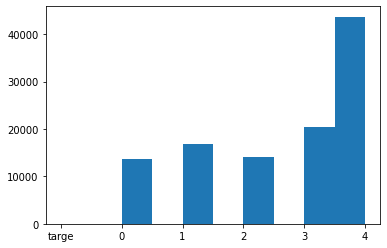

In [0]:
plt.hist(data['target'])
plt.show()

##Использование счетчика векторов и логистической регрессии

Метка 	 Accuracy 	 	 f1_score
0 	 0.9482295482295482 	 0.9482295482295482
1 	 0.9715220319415047 	 0.9715220319415047
2 	 0.8769489086111777 	 0.8769489086111777
3 	 0.908311345646438 	 0.908311345646438
4 	 0.9896278218425869 	 0.9896278218425869


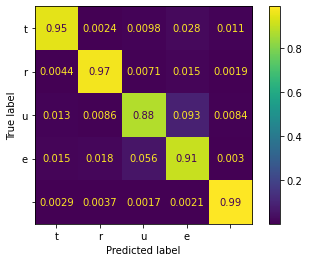

In [0]:
sentiment(CountVectorizer(), LogisticRegression(C=3.0))

##Использование Tfid Vectorizer и LinearSVC

Метка 	 Accuracy 	 	 f1_score
0 	 0.960927960927961 	 0.960927960927961
1 	 0.9722917067538965 	 0.9722917067538965
2 	 0.905492923962581 	 0.905492923962581
3 	 0.9147427440633246 	 0.9147427440633245
4 	 0.9925259304453935 	 0.9925259304453935


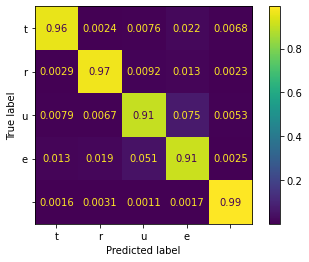

In [0]:
sentiment(TfidfVectorizer(), LinearSVC())

##Использование графа векторизатора и полиномиального наивного байесовского

Метка 	 Accuracy 	 	 f1_score
0 	 0.9252747252747253 	 0.9252747252747253
1 	 0.9601693284587262 	 0.9601693284587262
2 	 0.8807867594147277 	 0.8807867594147277
3 	 0.9094656992084432 	 0.9094656992084432
4 	 0.976738865161684 	 0.976738865161684


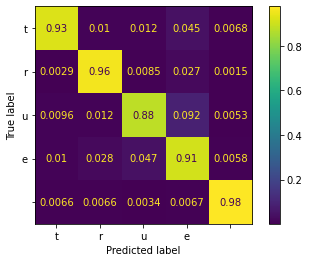

In [0]:
sentiment(CountVectorizer(), MultinomialNB())

##Использование графа векторизатора и наивного байесовского Бернулли

Метка 	 Accuracy 	 	 f1_score
0 	 0.8402930402930403 	 0.8402930402930403
1 	 0.9486242062728497 	 0.9486242062728497
2 	 0.8855840729191653 	 0.8855840729191653
3 	 0.8751649076517151 	 0.875164907651715
4 	 0.9775015253203173 	 0.9775015253203173


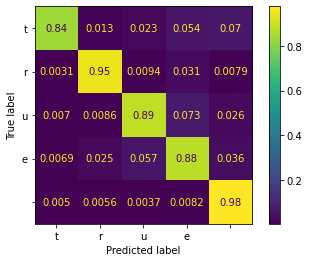

In [0]:
sentiment(CountVectorizer(binary=True), BernoulliNB())

##Использование Tfid Vectorizer и дополнения наивного байесовского

Метка 	 Accuracy 	 	 f1_score
0 	 0.9108669108669109 	 0.9108669108669109
1 	 0.9686357513950355 	 0.9686357513950355
2 	 0.8486447589349964 	 0.8486447589349964
3 	 0.912763852242744 	 0.9127638522427439
4 	 0.9912294081757169 	 0.9912294081757169


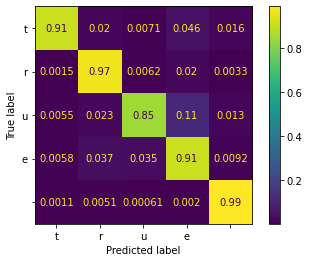

In [0]:
sentiment(TfidfVectorizer(), ComplementNB())


#Вывод
Мы видим, что лучшим классификатором при работе с данными был LinearSVC, поскольку он получил классификацию всех классов данных с точностью более 90 процентов. Это было сделано с использованием Tfid Vectorizor, что является сокращением от Term Frequency (TF) и Inverse Document Frequency (IDF). в то время как LinearSVC возвращает «наиболее подходящую» гиперплоскость, которая разделяет или классифицирует данные.

#Список литературы
1. Набор данных был взят с сайта: https://data.mendeley.com/datasets/v524p5dhpj/2
2. Лекции по курсу «Методы машинного обучения»